# Projet 5 - Segmentez des clients d'un site e-commerce

Le but de ce projet est de proposer une segmentation client d'une plateforme de commerce en ligne. 

Le premier notebook consiste en la sélection des variables pertinentes et la création du dataframe.

Dans ce second notebook nous allons explorer différents modèles de clustering afin de proposoer une segmentation de clients actionnable, ainsi qu'un contrat de maintenance.

Le dataset est disponible à l'adresse suivante:
https://www.kaggle.com/olistbr/brazilian-ecommerce


II. Clustering
- Kmeans
- DBScan
- Segmentation RFM

In [1]:
# Import des librairies
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import NearestNeighbors
from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from functions import *
from functools import reduce
import time
import random
import os

# Version des modules
print('Pandas:', pd.__version__)
print('Matplotlib:', matplotlib.__version__)
print('Numpy:', np.__version__)
print('Seaborn:', sns.__version__)
print('Scikit-learn:', sklearn.__version__)

Pandas: 1.0.5
Matplotlib: 3.2.2
Numpy: 1.19.5
Seaborn: 0.11.1
Scikit-learn: 0.23.1


In [2]:
# On renseigne une valeur de random seed de façon 
# à ce que le notebook soit reproductible
random.seed(10)

In [3]:
# Thème de seaborn
sns.set(style='ticks', font_scale=1.4)

In [4]:
# Chargement des datasets
data = pd.read_csv('data.csv')
data = data.set_index('customer_unique_id')

In [165]:
data

Recence  Frequence  Montant  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2      111          1   141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1    27.19   
0000f46a3911fa3c0805444483337064      536          1    86.22   
0000f6ccb0745a6a4b88665a16c9f078      320          1    43.62   
0004aac84e0df4da2b147fca70cf8255      287          1   196.89   
...                                   ...        ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684      446          1  2067.42   
fffea47cd6d3cc0a88bd621562a9d061      261          1    84.58   
ffff371b4d645b6ecea244b27531430a      567          1   112.46   
ffff5962728ec6157033ef9805bacc48      118          1   133.69   
ffffd2657e2aad2907e67c3e9daecbeb      483          1    71.56   

                                  delai_livraison  retard_livraison  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2              6.0              -5.0   
0000b849f77a49e4a4ce2b2a4ca5be3f              3.0              -5.0   
0000f46a3911fa3c0805444483337064             25.0              -2.0   
0000f6ccb0745a6a4b88665a16c9f078             20.0             -12.0   
0004aac84e0df4da2b147fca70cf8255             13.0              -8.0   
...                                           ...               ...   
fffcf5a5ff07b0908bd4e2dbc735a684             27.0             -27.0   
fffea47cd6d3cc0a88bd621562a9d061             30.0              -3.0   
ffff371b4d645b6ecea244b27531430a             14.0             -30.0   
ffff5962728ec6157033ef9805bacc48             11.0             -14.0   
ffffd2657e2aad2907e67c3e9daecbeb              7.0             -16.0   

                                  review_score  payment_installments  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2           5.0                   8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f           4.0                   1.0   
0000f46a3911fa3c0805444483337064           3.0                   8.0   
0000f6ccb0745a6a4b88665a16c9f078           4.0                   4.0   
0004aac84e0df4da2b147fca70cf8255           5.0                   6.0   
...                                        ...                   ...   
fffcf5a5ff07b0908bd4e2dbc735a684           5.0                  10.0   
fffea47cd6d3cc0a88bd621562a9d061           4.0                   1.0   
ffff371b4d645b6ecea244b27531430a           5.0                   1.0   
ffff5962728ec6157033ef9805bacc48           5.0                   5.0   
ffffd2657e2aad2907e67c3e9daecbeb           5.0                   4.0   

                                  categories_alimentation  categories_animaux  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                        0                   0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        0                   0   
0000f46a3911fa3c0805444483337064                        0                   0   
0000f6ccb0745a6a4b88665a16c9f078                        0                   0   
0004aac84e0df4da2b147fca70cf8255                        0                   0   
...                                                   ...                 ...   
fffcf5a5ff07b0908bd4e2dbc735a684                        0                   0   
fffea47cd6d3cc0a88bd621562a9d061                        0                   0   
ffff371b4d645b6ecea244b27531430a                        0                   0   
ffff5962728ec6157033ef9805bacc48                        0                   0   
ffffd2657e2aad2907e67c3e9daecbeb                        0                   0   

                                  categories_automobile  ...  \
customer_unique_id                                       ...   
0000366f3b9a7992bf8c76cfdf3221e2                      0  ...   
0000b849f77a49e4a4ce2b2a4ca5be3f                      0  ...   
0000f46a3911fa3c0

Un retard de livraison négatif signifie que le colis est arrivé en avance par rapport à la date estimée.

In [166]:
liste_num = ['Recence', 
             'Frequence', 
             'Montant', 
             'delai_livraison',
             'retard_livraison', 
             'review_score', 
             'payment_installments']

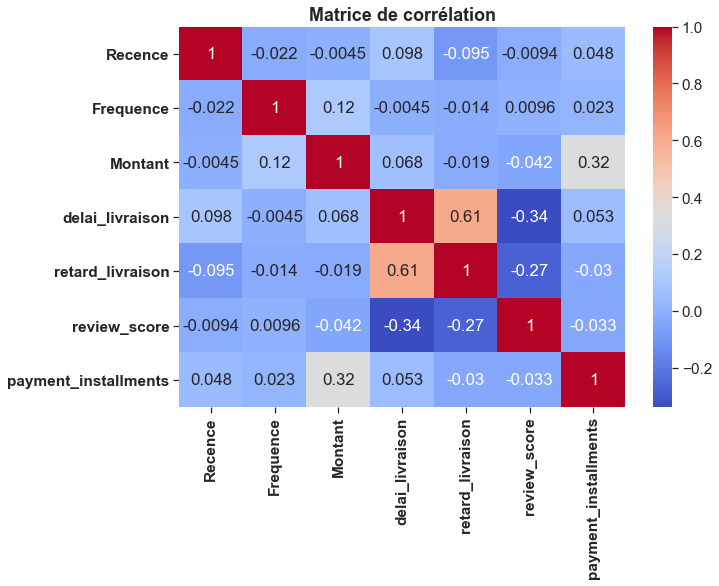

In [170]:
# Matrice de corrélation
df_corr = data[liste_num].corr()
f,ax=plt.subplots(figsize=(10,7))
sns.heatmap(df_corr, cmap = 'coolwarm',
           annot = True)
plt.title("Matrice de corrélation", 
          weight='bold', 
          fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold')

plt.show()

On peut remarquer que le retard de livraison est corrélé au délai de livraison (de grands délais engendrent de grands retards) et anti-corrélé au review score moyen (des délais de livraison courts engendrent des meilleurs avis).

On remarque aussi que les variables *Montant* et *payment_installments* sont un peu corrélées, puisque plus le prix est élevé plus on sera susceptible de payer en plusieurs fois.

Dans la suite on réalisera systématiquement une ACP avant de calculer nos clusters, on ne se soucie donc pas ici d'avoir des variables corrélées.

On peut afficher la variance expliquée par nombre de composantes d'ACP:

In [171]:
# Scaling
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(data)

# Choix du nombre de composantes à calculer
n_comp = X_scaled.shape[1]

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(n_components=50)

In [172]:
data.shape

(92056, 50)

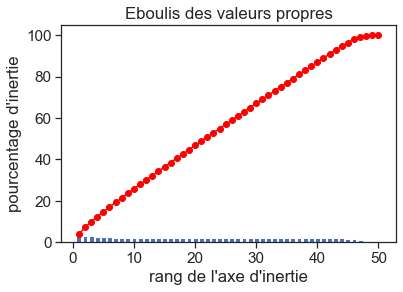

In [173]:
# Eboulis des valeurs propres
display_scree_plot(pca)
scree = pca.explained_variance_ratio_*100

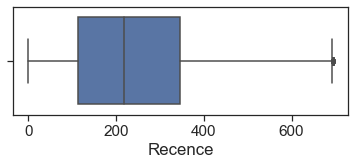

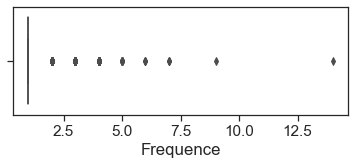

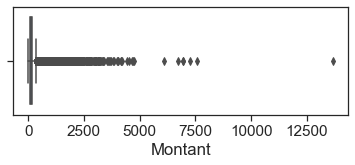

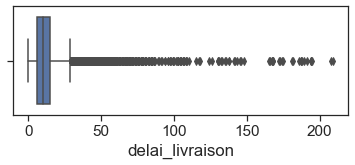

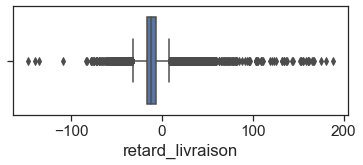

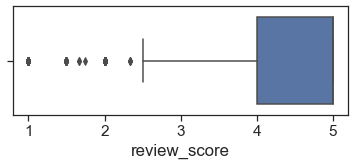

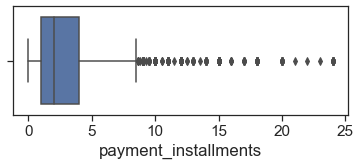

In [175]:
# Boxplot des variables quantitatives
for col in liste_num:   
    plt.figure(figsize=(6, 2))
    sns.boxplot(x=col, data=data)

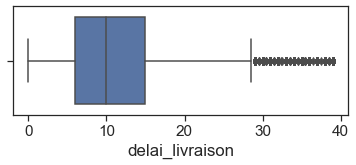

In [176]:
# Zoom sur délais de livraison
delai = data[data['delai_livraison']<40]
plt.figure(figsize=(6, 2))
sns.boxplot(x='delai_livraison', data=delai)

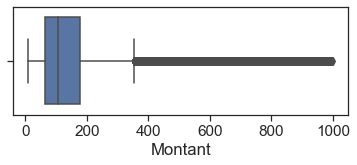

In [177]:
# Zoom sur Montant
montant = data[data['Montant']<1000]
plt.figure(figsize=(6, 2))
sns.boxplot(x='Montant', data=montant)

In [178]:
def tracer_distrib(df):
    """
    Fonction permettant de représenter la distribution des colonnes d'un dataframe
    """
    df = df.select_dtypes(include=np.number)
    n_feat = df.shape[1]
    if n_feat == 0:
        return
    elif n_feat % 4 == 0:
        n_row = int(n_feat/4)
    else:
        n_row = int(n_feat/4) + 1
   
    fig = plt.figure(figsize=(16, n_row*4))
    for feat_idx in range(n_feat):
        ax = fig.add_subplot(n_row, 4, (feat_idx+1))
        h = ax.hist(df.iloc[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
        name = '\n' + df.columns[feat_idx]
        ax.set_title(name, fontsize=14)
    plt.show()

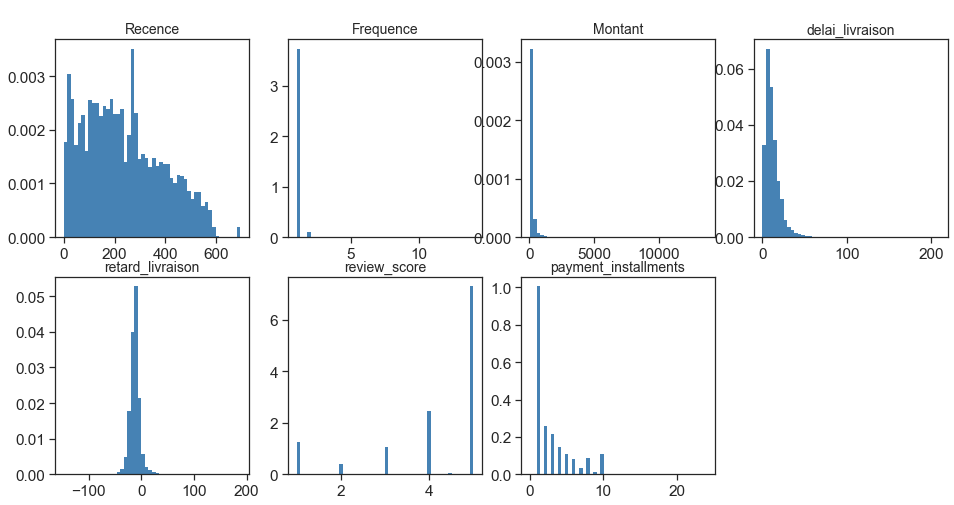

In [179]:
tracer_distrib(data[liste_num])

### Clustering
#### KMeans, avec toutes les variables
Notre premier algorithme de clustering est le KMeans. En première approche on garde toutes les variables précédemment définies. On réalise toujours une normalisation de nos features et une ACP.
Quatre scores différents permettant de mesurer la pertinence de nos clusters sont systématiquement calculés:
- WCSS (variance intra-cluster)
- silhouette
- Davies-Bouldin
- Calinski-Harabasz

In [14]:
def train_kmeans(data, pca_components, verbose=1, save_all=False, save=True, name_csv='results_kmeans'):
    model = 'KMeans'
    hyp_param = 'k'
    clusters = list(range(2,16))
    results_km = []
    cwd = os.getcwd()
    path = cwd + '/' + name_csv +  '.csv'
    columns = ['Modèle', 
               'n_pca', 
               'Hyperparamètre', 
               'Hyp. Opt.', 
               'WCSS', 
               'Silhouette', 
               'Davies_Bouldin', 
               'Calisnki-Har.', 
               'Temps de calcul']
    
    # Scaling
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    for n in pca_components:
        
        # Réduction de dimension
        pca = PCA(n_components=n)
        X_pca = pca.fit_transform(X_scaled)
        variance_expl = sum(pca.explained_variance_ratio_)
        
        for k in clusters:
            start = time.time()
            
            # Clustering
            KMModel = KMeans(n_clusters=k, 
                             init='k-means++',
                             random_state = 10)
            KMModel.fit(X_pca)
            wcss = round(KMModel.inertia_)
            
            # Scores
            silhouette = round(silhouette_score(X_pca, KMModel.labels_),3)
            davies_bouldin = round(davies_bouldin_score(X_pca, KMModel.labels_),3)
            calinski_harabasz = round(calinski_harabasz_score(X_pca, KMModel.labels_))
            temps = round(time.time() - start)
            
            # Enregistrement des résultats
            results_km.append([model, n, hyp_param, k, wcss, silhouette , davies_bouldin, calinski_harabasz, temps])
            if verbose == 1:
                print("model =", model, "    n_pca = ", n,  "    clusters=", k, '\n',
                      "within cluster SS = ", wcss, '\n',
                      "silhouette_score =", silhouette,'\n',
                      "davies_bouldin_score =", davies_bouldin,'\n',
                      "calinski_harabasz_score =", calinski_harabasz,'\n',
                      "temps de calcul: ", temps,
                      "\n\n", "-------------------------------", "\n")
                
            # Sauvegarde au format .csv après chaque ligne de résultat (protection contre les crashs)
            if save_all == True:
                df = pd.DataFrame(results_km, columns=columns)
                df.to_csv(path)
    df = pd.DataFrame(results_km, columns=columns)
    
    # Sauvegarde au format .csv
    if save==True:
        df.to_csv(path)
    return df

In [43]:
%%time
pca_components = [25, 35, 45]
results_kmeans_with_states = train_kmeans(data, pca_components, save_all=True, name_csv='results_kmeans_with_states')
results_kmeans_with_states

model = KMeans     n_pca =  25     clusters= 2 
 within cluster SS =  2454078 
 silhouette_score = 0.082 
 davies_bouldin_score = 3.4 
 calinski_harabasz_score = 5377 
 temps de calcul:  169 

 ------------------------------- 

model = KMeans     n_pca =  25     clusters= 3 
 within cluster SS =  2356886 
 silhouette_score = 0.09 
 davies_bouldin_score = 3.206 
 calinski_harabasz_score = 4698 
 temps de calcul:  165 

 ------------------------------- 

model = KMeans     n_pca =  25     clusters= 4 
 within cluster SS =  2272749 
 silhouette_score = 0.118 
 davies_bouldin_score = 3.061 
 calinski_harabasz_score = 4384 
 temps de calcul:  168 

 ------------------------------- 

model = KMeans     n_pca =  25     clusters= 5 
 within cluster SS =  2182122 
 silhouette_score = 0.132 
 davies_bouldin_score = 2.793 
 calinski_harabasz_score = 4380 
 temps de calcul:  168 

 ------------------------------- 

model = KMeans     n_pca =  25     clusters= 6 
 within cluster SS =  2127113 
 sil

model = KMeans     n_pca =  45     clusters= 10 
 within cluster SS =  3517908 
 silhouette_score = 0.129 
 davies_bouldin_score = 2.293 
 calinski_harabasz_score = 2675 
 temps de calcul:  169 

 ------------------------------- 

model = KMeans     n_pca =  45     clusters= 11 
 within cluster SS =  3423743 
 silhouette_score = 0.14 
 davies_bouldin_score = 2.18 
 calinski_harabasz_score = 2727 
 temps de calcul:  171 

 ------------------------------- 

model = KMeans     n_pca =  45     clusters= 12 
 within cluster SS =  3325755 
 silhouette_score = 0.161 
 davies_bouldin_score = 2.418 
 calinski_harabasz_score = 2798 
 temps de calcul:  170 

 ------------------------------- 

model = KMeans     n_pca =  45     clusters= 13 
 within cluster SS =  3232599 
 silhouette_score = 0.168 
 davies_bouldin_score = 2.256 
 calinski_harabasz_score = 2860 
 temps de calcul:  172 

 ------------------------------- 

model = KMeans     n_pca =  45     clusters= 14 
 within cluster SS =  3137390

Modèle  n_pca Hyperparamètre  Hyp. Opt.     WCSS  Silhouette  \
0   KMeans     25              k          2  2454078       0.082   
1   KMeans     25              k          3  2356886       0.090   
2   KMeans     25              k          4  2272749       0.118   
3   KMeans     25              k          5  2182122       0.132   
4   KMeans     25              k          6  2127113       0.139   
5   KMeans     25              k          7  2046158       0.149   
6   KMeans     25              k          8  1964678       0.164   
7   KMeans     25              k          9  1897922       0.182   
8   KMeans     25              k         10  1847461       0.177   
9   KMeans     25              k         11  1780970       0.198   
10  KMeans     25              k         12  1709384       0.216   
11  KMeans     25              k         13  1668864       0.212   
12  KMeans     25              k         14  1616789       0.227   
13  KMeans     25              k         15  1569052       0.236   
14  KMeans     35              k          2  3396089       0.068   
15  KMeans     35              k          3  3302723       0.064   
16  KMeans     35              k          4  3218195       0.095   
17  KMeans     35              k          5  3115417       0.100   
18  KMeans     35              k          6  3026678       0.112   
19  KMeans     35              k          7  2934399       0.125   
20  KMeans     35              k          8  2862748       0.142   
21  KMeans     35              k          9  2774843       0.146   
22  KMeans     35              k         10  2703423       0.164   
23  KMeans     35              k         11  2632372       0.169   
24  KMeans     35              k         12  2534016       0.183   
25  KMeans     35              k         13  2448202       0.194   
26  KMeans     35              k         14  2360943       0.212   
27  KMeans     35              k         15  2284987       0.223   
28  KMeans     45              k          2  4291417       0.057   
29  KMeans     45              k          3  4187588       0.026   
30  KMeans     45              k          4  4094886       0.031   
31  KMeans     45              k          5  4001010       0.041   
32  KMeans     45              k          6  3905214       0.058   
33  KMeans     45              k          7  3812669       0.052   
34  KMeans     45              k          8  3709577       0.097   
35  KMeans     45              k          9  3611118       0.121   
36  KMeans     45              k         10  3517908       0.129   
37  KMeans     45              k         11  3423743       0.140   
38  KMeans     45              k         12  3325755       0.161   
39  KMeans     45              k         13  3232599       0.168   
40  KMeans     45              k         14  3137390       0.185   
41  KMeans     45              k         15  3044737       0.194   

    Davies_Bouldin  Calisnki-Har.  Temps de calcul  
0            3.400           5377              169  
1            3.206           4698              165  
2            3.061           4384              168  
3            2.793           4380              168  
4            2.523           4071              169  
5            2.534           4133              169  
6            2.083           4235              171  
7            2.189           4241              171  
8            2.142           4152              170  
9            1.909           4220              171  
10           1.790           4347              170  
11           1.841           4268              171  
12           1.711           4294              173  
13           1.770           4309              171  
14           3.811           3928              172  
15           4.429           3321              167  
16           2.726           3078              239  
17           3.209           3144              173  
18           2.894           3128              181  
19           2.698 

In [6]:
results_kmeans_with_states = pd.read_csv('results_kmeans_with_states.csv')

In [44]:
results_kmeans_with_states

Modèle  n_pca Hyperparamètre  Hyp. Opt.     WCSS  Silhouette  \
0   KMeans     25              k          2  2454078       0.082   
1   KMeans     25              k          3  2356886       0.090   
2   KMeans     25              k          4  2272749       0.118   
3   KMeans     25              k          5  2182122       0.132   
4   KMeans     25              k          6  2127113       0.139   
5   KMeans     25              k          7  2046158       0.149   
6   KMeans     25              k          8  1964678       0.164   
7   KMeans     25              k          9  1897922       0.182   
8   KMeans     25              k         10  1847461       0.177   
9   KMeans     25              k         11  1780970       0.198   
10  KMeans     25              k         12  1709384       0.216   
11  KMeans     25              k         13  1668864       0.212   
12  KMeans     25              k         14  1616789       0.227   
13  KMeans     25              k         15  1569052       0.236   
14  KMeans     35              k          2  3396089       0.068   
15  KMeans     35              k          3  3302723       0.064   
16  KMeans     35              k          4  3218195       0.095   
17  KMeans     35              k          5  3115417       0.100   
18  KMeans     35              k          6  3026678       0.112   
19  KMeans     35              k          7  2934399       0.125   
20  KMeans     35              k          8  2862748       0.142   
21  KMeans     35              k          9  2774843       0.146   
22  KMeans     35              k         10  2703423       0.164   
23  KMeans     35              k         11  2632372       0.169   
24  KMeans     35              k         12  2534016       0.183   
25  KMeans     35              k         13  2448202       0.194   
26  KMeans     35              k         14  2360943       0.212   
27  KMeans     35              k         15  2284987       0.223   
28  KMeans     45              k          2  4291417       0.057   
29  KMeans     45              k          3  4187588       0.026   
30  KMeans     45              k          4  4094886       0.031   
31  KMeans     45              k          5  4001010       0.041   
32  KMeans     45              k          6  3905214       0.058   
33  KMeans     45              k          7  3812669       0.052   
34  KMeans     45              k          8  3709577       0.097   
35  KMeans     45              k          9  3611118       0.121   
36  KMeans     45              k         10  3517908       0.129   
37  KMeans     45              k         11  3423743       0.140   
38  KMeans     45              k         12  3325755       0.161   
39  KMeans     45              k         13  3232599       0.168   
40  KMeans     45              k         14  3137390       0.185   
41  KMeans     45              k         15  3044737       0.194   

    Davies_Bouldin  Calisnki-Har.  Temps de calcul  
0            3.400           5377              169  
1            3.206           4698              165  
2            3.061           4384              168  
3            2.793           4380              168  
4            2.523           4071              169  
5            2.534           4133              169  
6            2.083           4235              171  
7            2.189           4241              171  
8            2.142           4152              170  
9            1.909           4220              171  
10           1.790           4347              170  
11           1.841           4268              171  
12           1.711           4294              173  
13           1.770           4309              171  
14           3.811           3928              172  
15           4.429           3321              167  
16           2.726           3078              239  
17           3.209           3144              173  
18           2.894           3128              181  
19           2.698 

In [22]:
def tracer_scores(df_resultats):
    # Réarrangement des colonnes
    scores = ['WCSS', 'Silhouette', 'Davies_Bouldin', 'Calisnki-Har.']
    columns = ['n_pca', 'Hyp. Opt.', 'score_value', 'score_type']
    df0 = df_resultats[['n_pca', 'Hyp. Opt.']]
    df_res = pd.DataFrame(columns=columns)
    for s in scores:
        df = df0.copy()
        df['score_value'] = df_resultats[s].copy()
        df['score_type'] = s
        df_res = pd.concat([df_res, df], ignore_index=True)

    df_res = df_res.astype({'n_pca': 'int32',
                  'Hyp. Opt.': 'int32',
                  'score_value':'float'})

    # Graphes scores
    sns.relplot(
        data=df_res, kind="line",
        x="Hyp. Opt.", 
        y="score_value", 
        hue="n_pca",
        facet_kws=dict(sharey=False),
        col="score_type",
        col_wrap=2,
        linewidth =3
    )

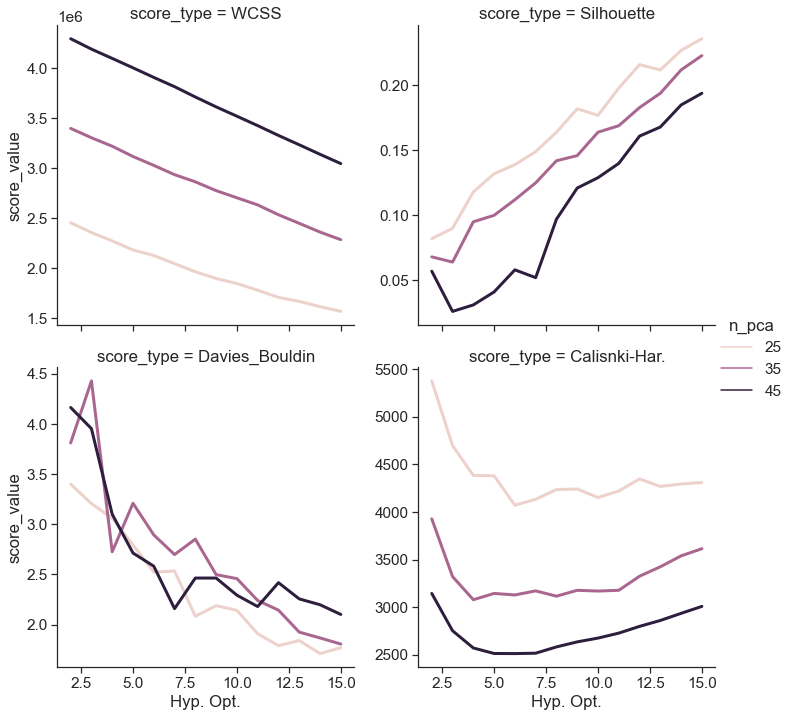

In [33]:
tracer_scores(results_kmeans_with_states)

Le graphe ci-dessus représente différents scores de validation interne, en fonction du nombre de clusters. Le nombre de clusters optimal est défini selon le type de score par:
- WCSS: au niveau du coude
- silhouette: le maximum
- Davies Bouldin: le minimum
- Calinski et Harabasz: le maximum

Comme on peut le voir ici il est impossible de déterminer un nombre de clusters optimal selon ces critères sur la plage de k étudiée. 

Pour rester dans un nombre de clusters raisonnable et actionnable, on se propose de regarder les résultats pour k=12. 

In [8]:
# Kmeans avec k = 12, n_pca=25
# Scaling
sc = preprocessing.StandardScaler()
X_scaled = sc.fit_transform(data)

# ACP
pca = PCA(n_components=25)
X_pca = pca.fit_transform(X_scaled)

# Clustering
km = KMeans(n_clusters=12,
           init='k-means++',
           random_state=10)
km.fit(X_pca)


KMeans(n_clusters=12, random_state=10)

In [9]:
data['clusters']=km.labels_

In [57]:
# Enregistrement des résultats dans le répertoire actuel
cwd = os.getcwd()
path = cwd + '/' + 'data' +  '.csv'
data.to_csv(path)

In [44]:
pd.set_option('display.max_columns', None)

In [49]:
data_mean = data.groupby(by='clusters').mean()
data_mean

Recence  Frequence     Montant  delai_livraison  \
clusters                                                       
0         241.410613   1.032571  169.952223        12.736081   
1         225.494617   1.033477  146.523844         8.300089   
2         246.225714   1.034795  175.177720        14.930475   
3         224.249874   1.030669  172.257371        12.427853   
4         249.138655   1.037311  176.558654        15.003305   
5         234.953342   1.029004  212.712585        16.854981   
6         252.521870   1.037276  204.653443        21.142075   
7         241.707859   1.035230  175.106293        15.114318   
8         241.304682   1.032072  192.511344        18.875978   
9         246.270610   1.028003  182.848063        15.136395   
10        241.214525   1.029811  164.984978        11.439500   
11        245.860465   1.026993  216.670739        18.636667   

          retard_livraison  review_score  payment_installments  \
clusters                                                         
0               -12.853150      4.173949              2.946792   
1               -11.277305      4.242983              2.676140   
2               -11.941203      3.951679              3.094951   
3               -12.117228      4.125608              2.775851   
4               -14.035644      4.155966              3.101583   
5               -11.939470      4.130937              2.905422   
6                -8.982829      3.891413              3.344976   
7               -12.226829      4.084146              3.042593   
8               -10.765865      3.909119              3.306062   
9               -11.867574      4.119057              2.941137   
10              -13.314642      4.179950              3.038772   
11              -13.031650      4.045681              3.652755   

          categories_alimentation  categories_animaux  categories_automobile  \
clusters                                                                       
0                        0.010979            0.013541               0.059652   
1                        0.014859            0.017161               0.056750   
2                        0.011105            0.014971               0.046969   
3                        0.009050            0.019608               0.065359   
4                        0.006723            0.073109               0.047899   
5                        0.011349            0.114754               0.049180   
6                        0.024133            0.008188               0.057531   
7                        0.007588            0.011924               0.048780   
8                        0.008980            0.019564               0.059654   
9                        0.009160            0.022769               0.062549   
10                       0.007058            0.017552               0.067143   
11                       0.008721            0.014535               0.058555   

          categories_bebe  categories_bricolage  categories_bureau  \
clusters                                                             
0                0.058920              0.062946           0.039707   
1                0.030613              0.068924           0.042915   
2                0.027967              0.079872           0.050506   
3                0.034691              0.047763           0.031171   
4                0.038319              0.078655           0.040000   
5                0.040353              0.078184           0.037831   
6                0.033183              0.066365           0.047188   
7                0.028184              0.092683           0.037940   
8                0.030148              0.082745           0.053560   
9                0.029573              0.088720           0.082701   
10               0.032968              0.086367           0.039933   
11               0.025748              0.073505           0.038621   

          categories_cool_stuff  categories_divertissement  \
clusters                   

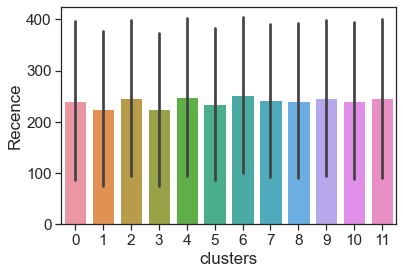

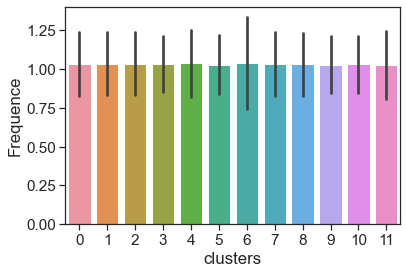

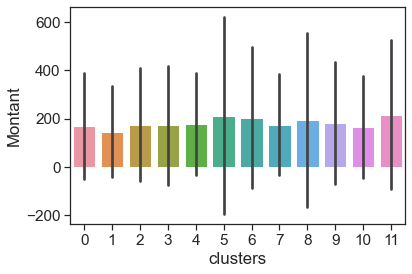

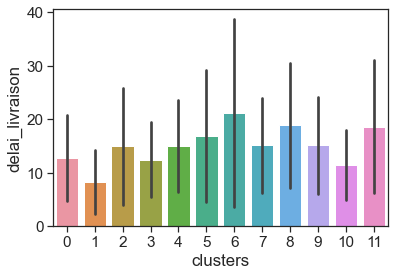

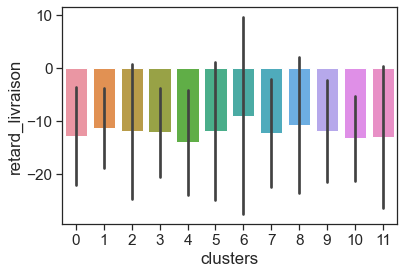

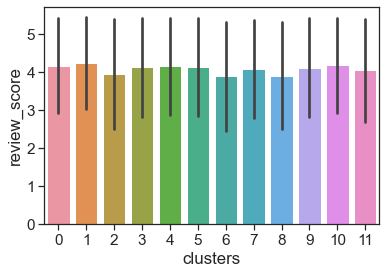

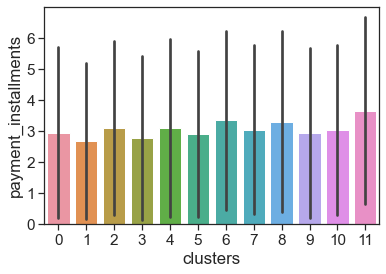

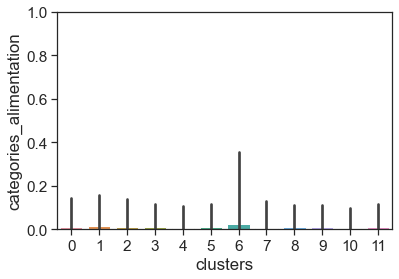

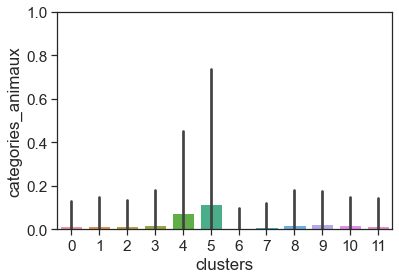

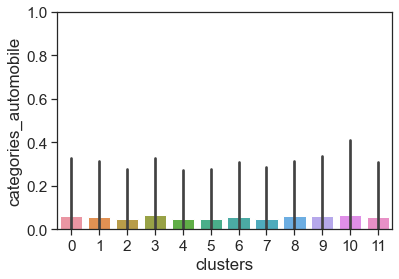

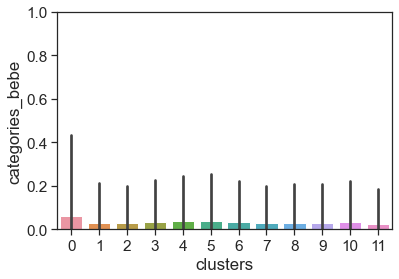

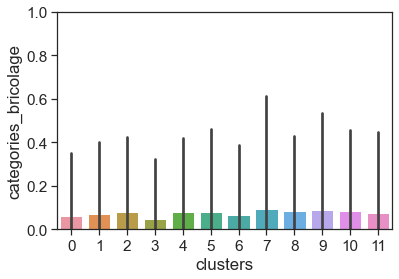

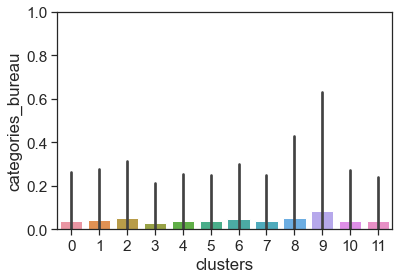

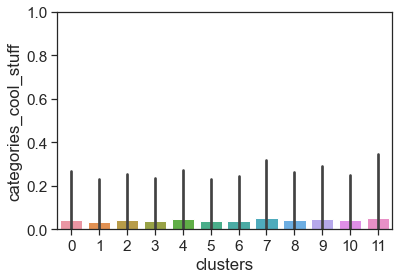

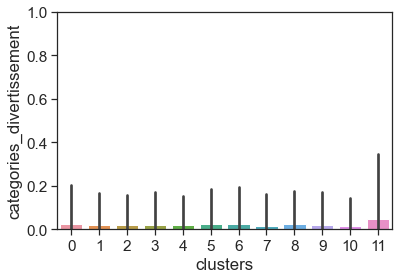

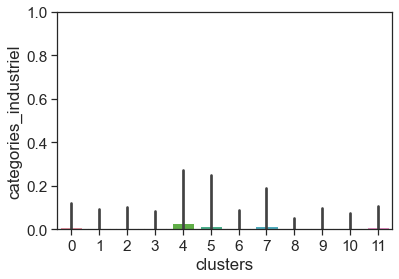

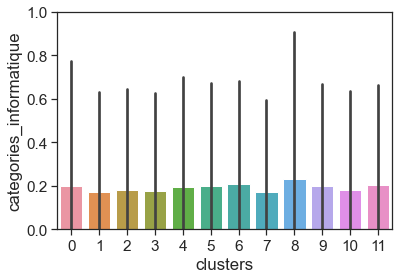

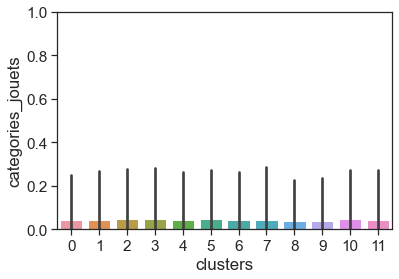

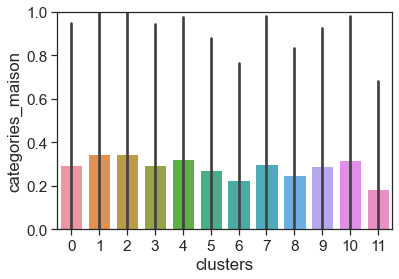

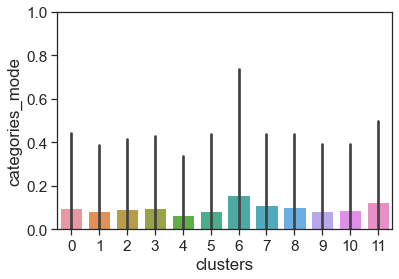

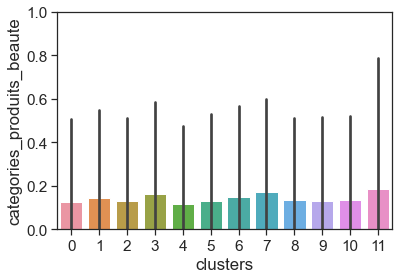

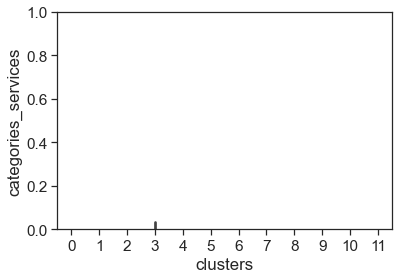

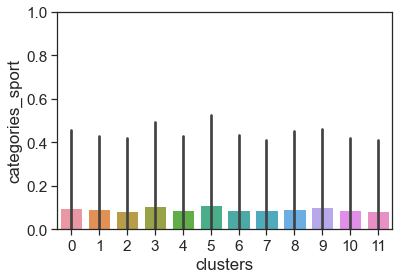

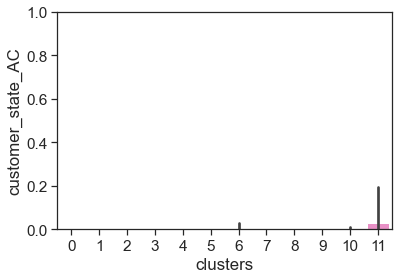

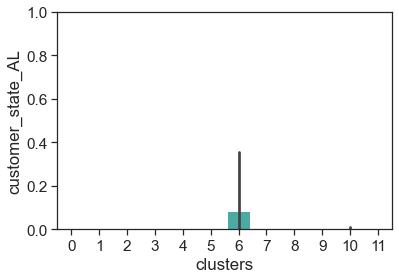

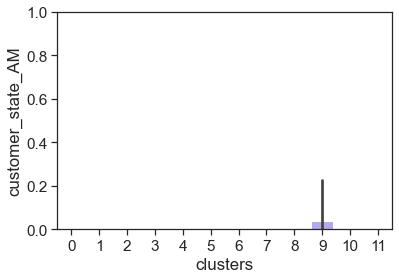

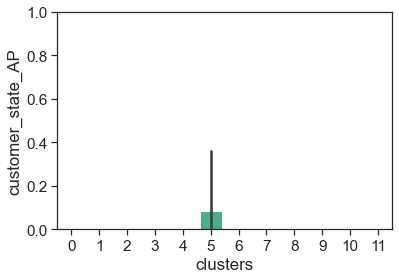

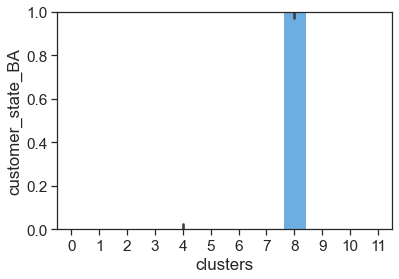

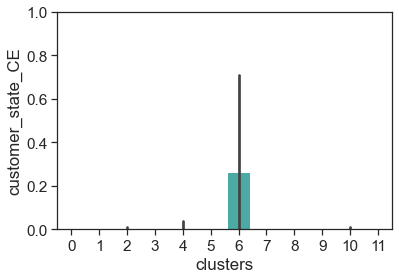

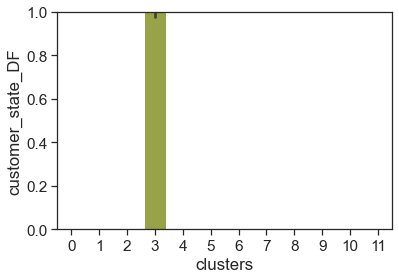

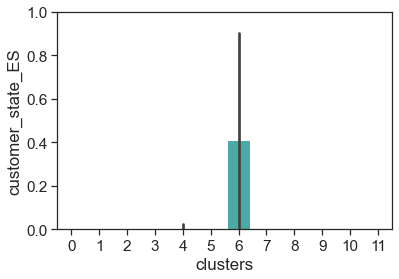

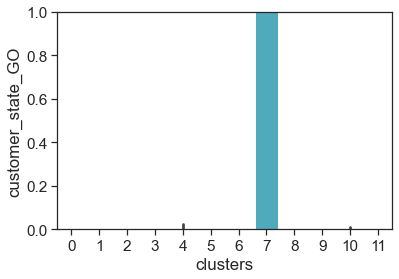

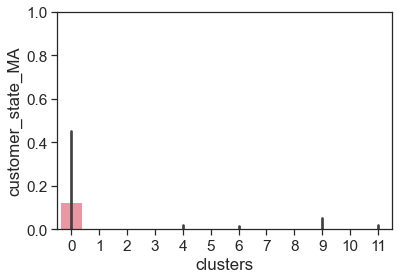

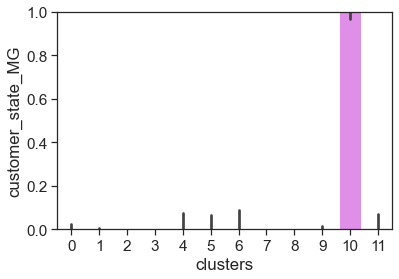

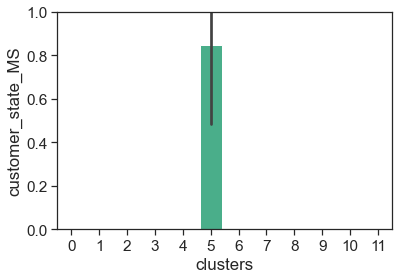

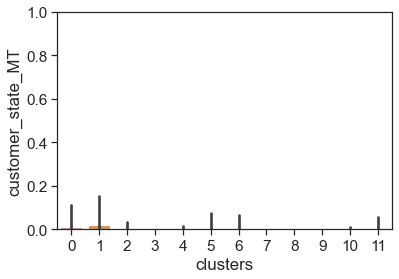

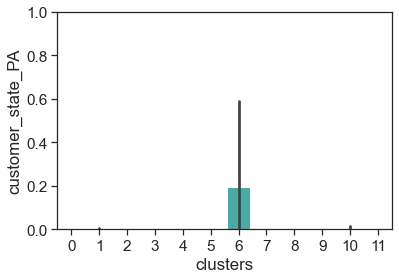

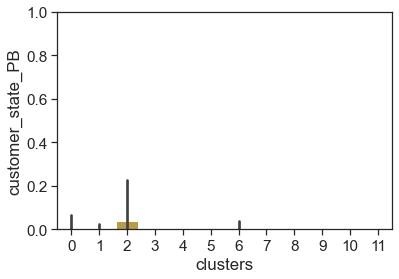

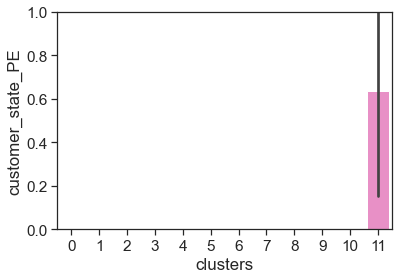

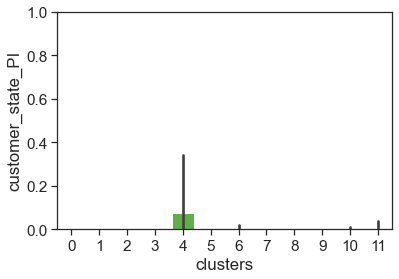

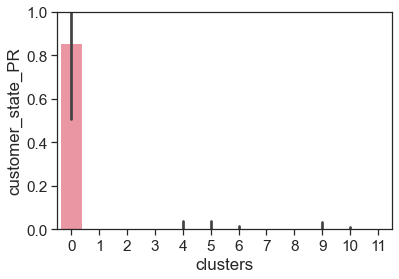

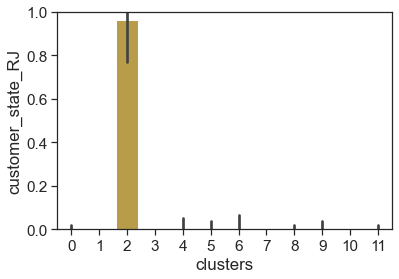

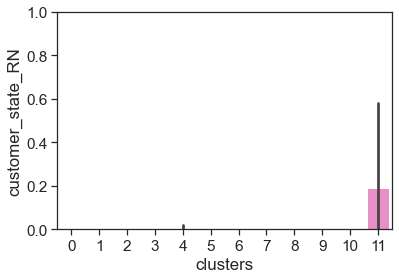

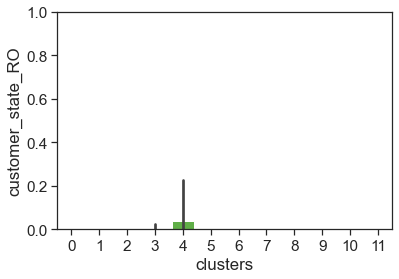

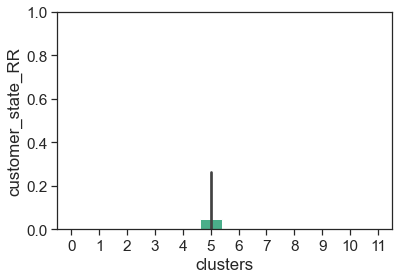

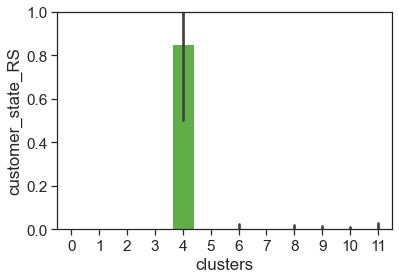

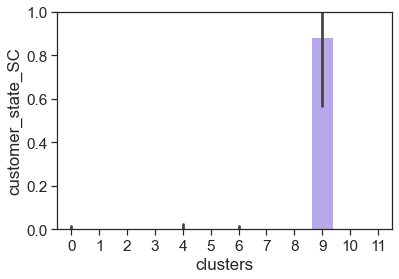

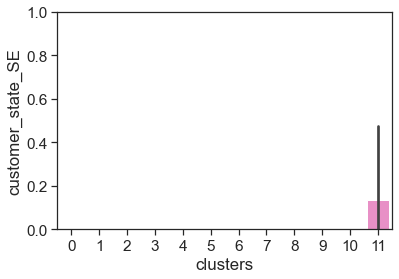

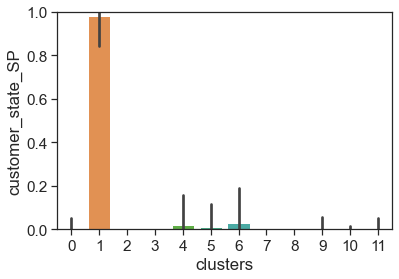

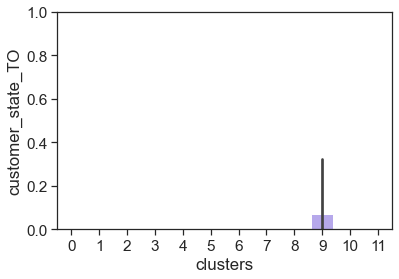

In [35]:
# Moyennes par cluster
index_cat = data.columns[7:-1]

for col in data.columns[:-1]:
    plt.figure() 
    sns.barplot(x="clusters", y=col, data=data, ci='sd')  # sd = écart-type
    if col in index_cat:
        plt.ylim(0,1)
    plt.show()  

On voit sur ces graphes (en particulier ceux concernant les états, en bas), que les clusters que nous avons formé sont très liés aux états, avec dans la plupart des cas des clients ne provenant que d'un même état par cluster, alors que la moyenne inter-clusters des autres variables ne varie que très peu.

Ce type de clustering ne nous parait pas très pertinent, on retente la même méthode mais sans les états cette fois, de façon à avoir plus d'insights sur les comportements des utilisateurs.

#### KMeans, Sans la variable états:

In [5]:
# Sans les états
data2 = data.iloc[:,:23]

In [6]:
data2.shape

(92056, 23)

On peut afficher la variance expliquée par nombre de composantes d'ACP:

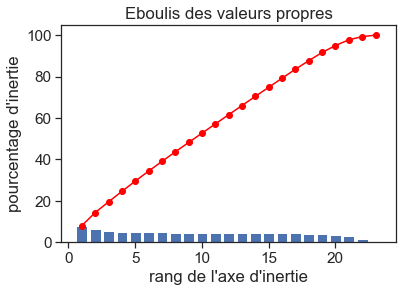

In [36]:
# Scaling
scaler = preprocessing.StandardScaler()
X_scaled2 = scaler.fit_transform(data2)
# Choix du nombre de composantes à calculer
n_comp = X_scaled2.shape[1]
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled2)
# Eboulis des valeurs propres
display_scree_plot(pca)
scree = pca.explained_variance_ratio_*100

In [39]:
%%time
pca_components = [10, 15, 20]
results_kmeans = train_kmeans(data2, pca_components, save_all=True, name_csv='results_kmeans')
results_kmeans

model = KMeans     n_pca =  10     clusters= 2 
 within cluster SS =  1019792 
 silhouette_score = 0.23 
 davies_bouldin_score = 2.203 
 calinski_harabasz_score = 8501 
 temps de calcul:  173 

 ------------------------------- 

model = KMeans     n_pca =  10     clusters= 3 
 within cluster SS =  946639 
 silhouette_score = 0.205 
 davies_bouldin_score = 2.291 
 calinski_harabasz_score = 8136 
 temps de calcul:  170 

 ------------------------------- 

model = KMeans     n_pca =  10     clusters= 4 
 within cluster SS =  872545 
 silhouette_score = 0.148 
 davies_bouldin_score = 1.617 
 calinski_harabasz_score = 8490 
 temps de calcul:  175 

 ------------------------------- 

model = KMeans     n_pca =  10     clusters= 5 
 within cluster SS =  796934 
 silhouette_score = 0.202 
 davies_bouldin_score = 1.552 
 calinski_harabasz_score = 9155 
 temps de calcul:  174 

 ------------------------------- 

model = KMeans     n_pca =  10     clusters= 6 
 within cluster SS =  725511 
 silho

model = KMeans     n_pca =  20     clusters= 10 
 within cluster SS =  1258430 
 silhouette_score = 0.204 
 davies_bouldin_score = 1.325 
 calinski_harabasz_score = 6117 
 temps de calcul:  170 

 ------------------------------- 

model = KMeans     n_pca =  20     clusters= 11 
 within cluster SS =  1180024 
 silhouette_score = 0.226 
 davies_bouldin_score = 1.251 
 calinski_harabasz_score = 6483 
 temps de calcul:  170 

 ------------------------------- 

model = KMeans     n_pca =  20     clusters= 12 
 within cluster SS =  1097361 
 silhouette_score = 0.271 
 davies_bouldin_score = 1.429 
 calinski_harabasz_score = 6968 
 temps de calcul:  172 

 ------------------------------- 

model = KMeans     n_pca =  20     clusters= 13 
 within cluster SS =  1043263 
 silhouette_score = 0.308 
 davies_bouldin_score = 1.236 
 calinski_harabasz_score = 7116 
 temps de calcul:  177 

 ------------------------------- 

model = KMeans     n_pca =  20     clusters= 14 
 within cluster SS =  95745

Modèle  n_pca Hyperparamètre  Hyp. Opt.     WCSS  Silhouette  \
0   KMeans     10              k          2  1019792       0.230   
1   KMeans     10              k          3   946639       0.205   
2   KMeans     10              k          4   872545       0.148   
3   KMeans     10              k          5   796934       0.202   
4   KMeans     10              k          6   725511       0.246   
5   KMeans     10              k          7   655578       0.284   
6   KMeans     10              k          8   598511       0.307   
7   KMeans     10              k          9   537769       0.345   
8   KMeans     10              k         10   499801       0.357   
9   KMeans     10              k         11   471254       0.355   
10  KMeans     10              k         12   448826       0.359   
11  KMeans     10              k         13   428677       0.356   
12  KMeans     10              k         14   417095       0.359   
13  KMeans     10              k         15   404156       0.362   
14  KMeans     15              k          2  1490157       0.184   
15  KMeans     15              k          3  1412316       0.202   
16  KMeans     15              k          4  1339234       0.112   
17  KMeans     15              k          5  1258070       0.135   
18  KMeans     15              k          6  1180002       0.173   
19  KMeans     15              k          7  1100202       0.250   
20  KMeans     15              k          8  1024465       0.259   
21  KMeans     15              k          9   951160       0.288   
22  KMeans     15              k         10   881290       0.308   
23  KMeans     15              k         11   800707       0.348   
24  KMeans     15              k         12   726519       0.377   
25  KMeans     15              k         13   658642       0.406   
26  KMeans     15              k         14   603900       0.418   
27  KMeans     15              k         15   566175       0.430   
28  KMeans     20              k          2  1912257       0.162   
29  KMeans     20              k          3  1820200       0.162   
30  KMeans     20              k          4  1737195       0.179   
31  KMeans     20              k          5  1668903       0.099   
32  KMeans     20              k          6  1586803       0.136   
33  KMeans     20              k          7  1511056       0.151   
34  KMeans     20              k          8  1430067       0.138   
35  KMeans     20              k          9  1343058       0.180   
36  KMeans     20              k         10  1258430       0.204   
37  KMeans     20              k         11  1180024       0.226   
38  KMeans     20              k         12  1097361       0.271   
39  KMeans     20              k         13  1043263       0.308   
40  KMeans     20              k         14   957453       0.319   
41  KMeans     20              k         15   882203       0.325   

    Davies_Bouldin  Calisnki-Har.  Temps de calcul  
0            2.203           8501              173  
1            2.291           8136              170  
2            1.617           8490              175  
3            1.552           9155              174  
4            1.451           9857              171  
5            1.326          10727              171  
6            1.427          11325              167  
7            1.281          12328              164  
8            1.104          12568              164  
9            1.179          12553              169  
10           1.083          12401              168  
11           1.103          12262              168  
12           1.116          11829              170  
13           1.089          11546              174  
14           2.531           5815              178  
15           2.283           5604              180  
16           1.832           5614              174  
17           1.864           5967              171  
18           1.726           6307              172  
19           1.664 

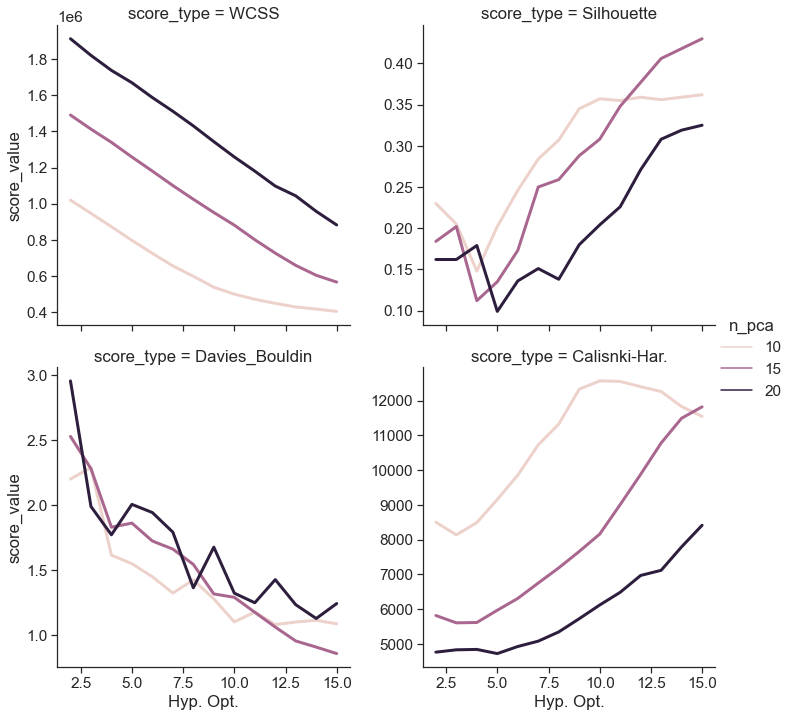

In [40]:
tracer_scores(results_kmeans)

Les scores ne sont pas beaucoup plus pertinents sans la variable "states". Le coude obtenu à k = 10 pour les courbes rose clair ne veut rien dire puisqu'il s'agit du maximum de composantes ACP.

In [48]:
# Kmeans avec k = 6, n_pca=10
# Scaling
sc = preprocessing.StandardScaler()
X_scaled = sc.fit_transform(data)

# ACP
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Clustering
km = KMeans(n_clusters=6,
           init='k-means++',
           random_state=10)
km.fit(X_pca)


KMeans(n_clusters=6, random_state=10)

In [49]:
data2['clusters']=km.labels_

In [43]:
# data_mean = data.groupby(by='clusters').mean()
# data_mean

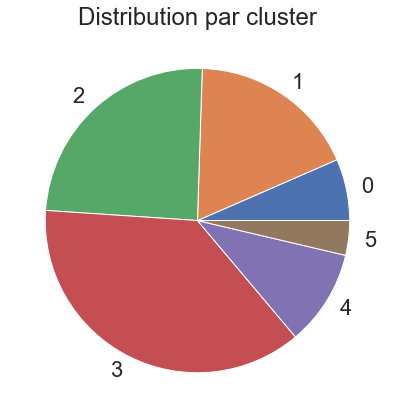

In [159]:
clust_size = data2.groupby(by='clusters').size()
plt.figure(figsize=(15, 7))
plt.title('Distribution par cluster')
plt.pie(clust_size, labels=clust_size.index)
plt.show()

In [157]:
# Thème de seaborn
sns.set(style='ticks', font_scale=2)

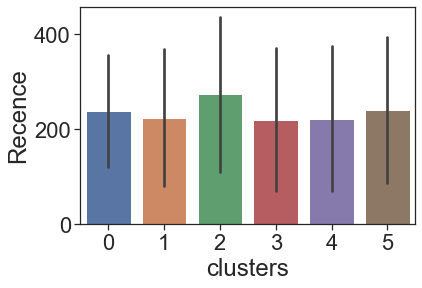

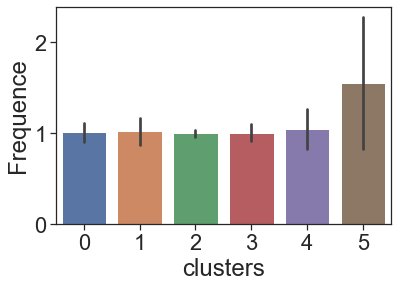

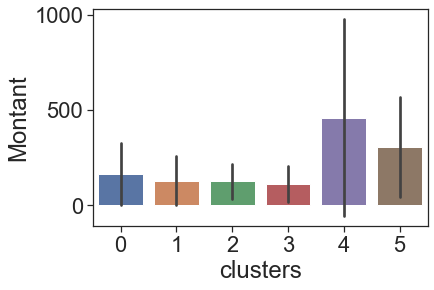

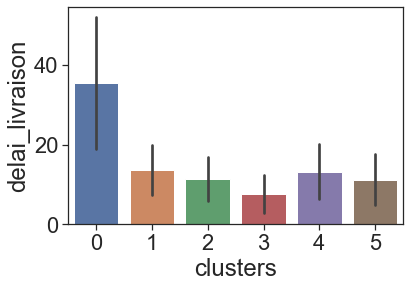

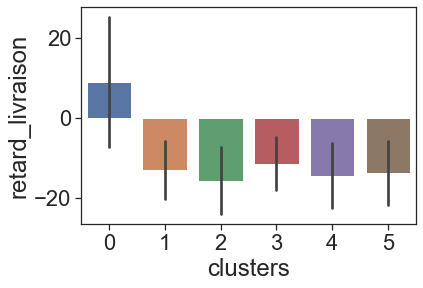

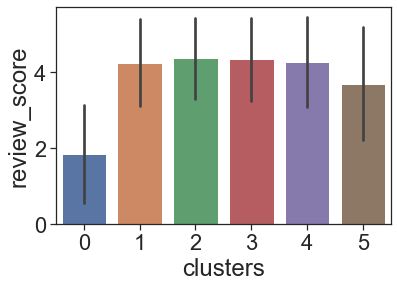

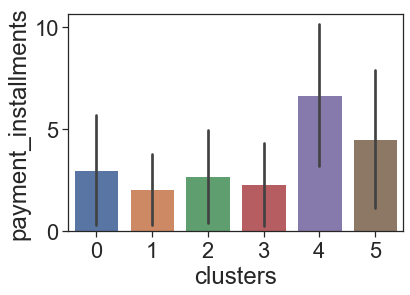

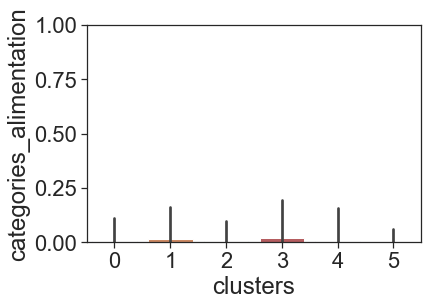

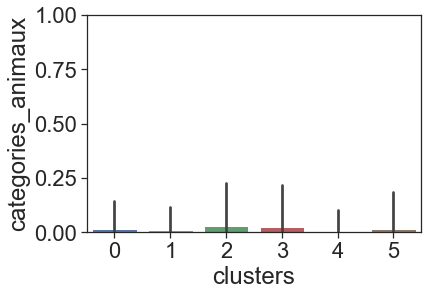

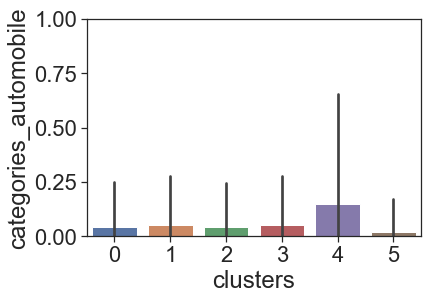

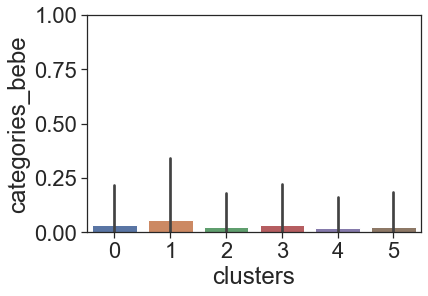

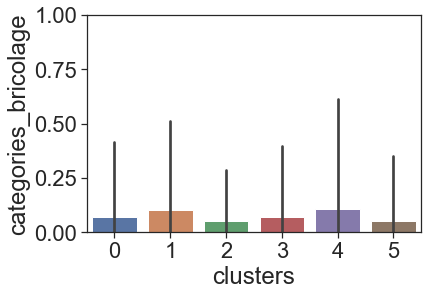

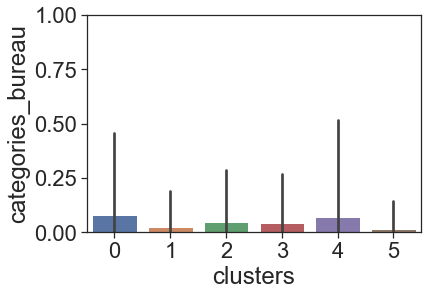

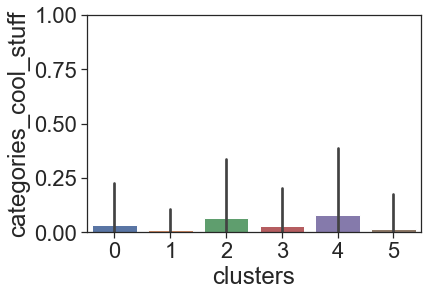

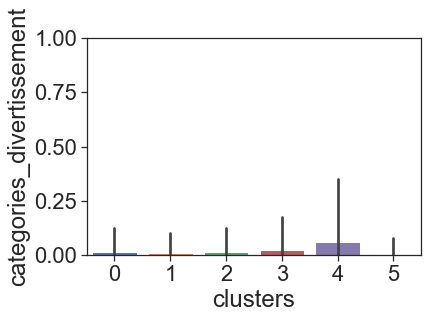

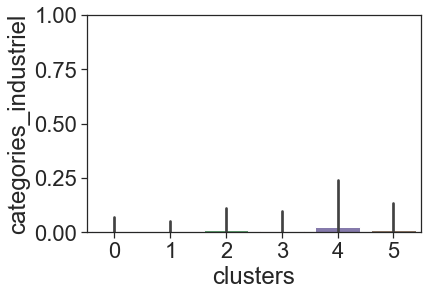

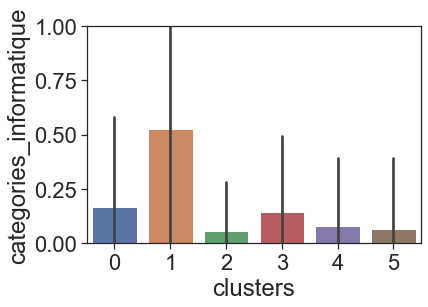

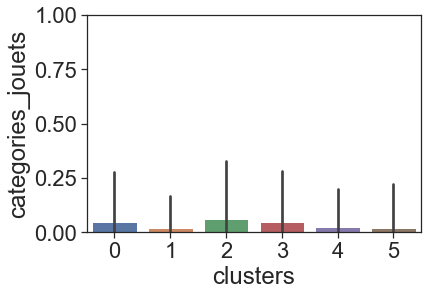

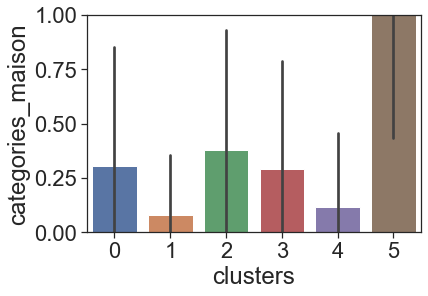

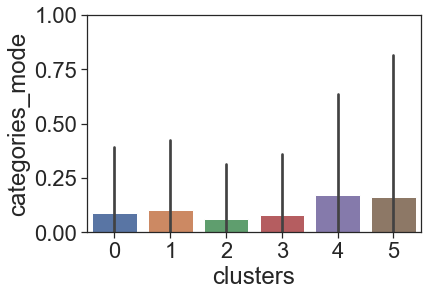

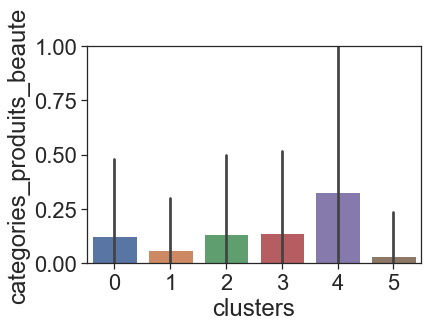

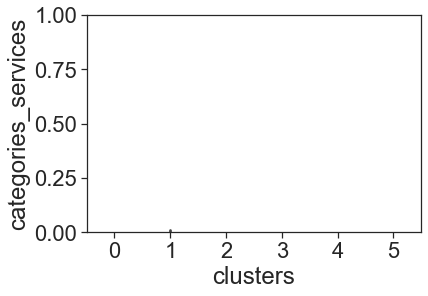

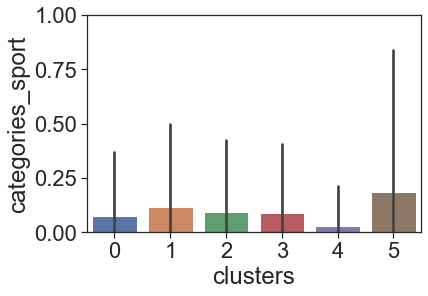

In [158]:
# Moyennes par cluster
index_cat2 = data2.columns[7:-1]

for col in data2.columns[:-1]:
    plt.figure() 
    sns.barplot(x="clusters", y=col, data=data2, ci='sd')
    if col in index_cat2:
        plt.ylim(0,1)
    plt.show()

- Cluster 0: 
- Cluster 1: récence la plus élevée, montants les plus élevés, fréquence d'achat relativement élevée, groupe de clients à prioriser
- Cluster 2:
- Cluster 3: montants les plus fiables, récence la plus faible, représente les nouveaux arrivants
- Cluster 4:
- Cluster 5: délai de livraison élevé, seul groupe ayant un retard positif en moyenne, ce qui explique des notes de review significativement plus basse des autres clusters, et que la fréquence est la plus faible (peu significatif ici)

#### Segmentation RFM
On peut segmenter "manuellement" les clients à l'aide du score Récence--Montant-Fréquence:

Définiton segments
- CORE - '123' - most recent, frequent, revenue generating - core customers that should be considered as most valuable clients
- GONE - '311', '312', '313' - gone, one-timers - those clients are probably gone
- ROOKIE - '111', '112', '113' - just have joined - new clients that have joined recently
- WHALES - '323', '213', '223 - most revenue generating - whales that generate revenue
- LOYAL - '221', '222', '321', '322' - loyal users
- REGULAR - '121', '122', '211', '212', - average users - just regular customers that don't stand out

In [24]:
def segment(x):
    if x == '123':
        return 'Core'
    elif x in ['311', '312', '313']:
        return 'Gone'
    elif x in ['111', '112', '113']:
        return 'Rookies'
    elif x in ['323', '213', '223']:
        return 'Whales'
    elif x in ['221', '222', '321', '322']:
        return 'Loyal'
    else:
        return 'Regular'

In [25]:
R_score = pd.qcut(data2['Recence'], 3, labels=[1, 2, 3]).astype(str)
M_score = pd.qcut(data2['Montant'], 3, labels=[1, 2, 3]).astype(str)
F_score = data2['Frequence'].apply(lambda x: '1' if x==1 else '2')

RFM_score = R_score + M_score + F_score

In [26]:
segments = RFM_score.apply(segment)

In [27]:
data2['segments']=segments

In [28]:
count_perc = segments.value_counts()/len(segments)

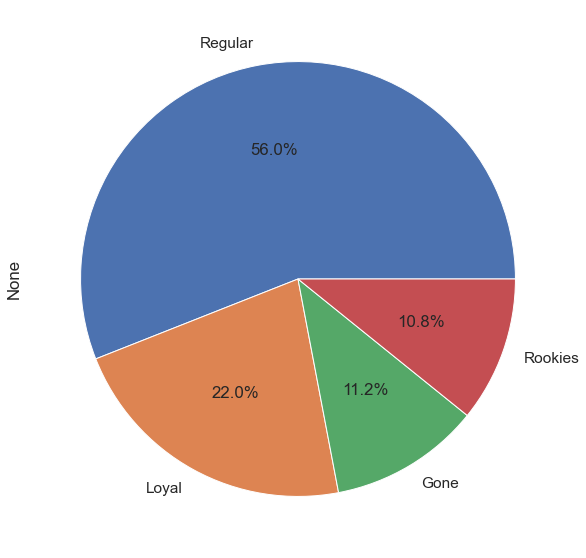

In [78]:
plt.figure()
count_perc.plot.pie(figsize=(10,10), autopct='%1.1f%%')
plt.show()

In [30]:
df_plot = data2.groupby(['clusters', 'segments']).size().reset_index().pivot(columns='segments', index='clusters', values=0)
df_plot

segments  Gone  Loyal  Regular  Rookies
clusters                               
0          356   1721     3670      226
1           25    558     6012        9
2         4595   7334    17696     5501
3         2632   5194    10971     2054
4         1141   2475     6658     1035
5         1573   2969     6535     1116

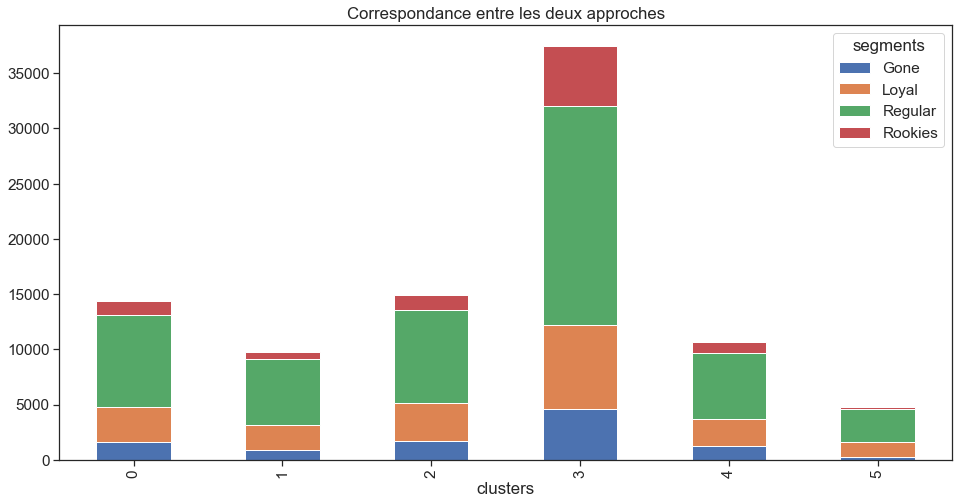

In [95]:
df_plot.plot(kind='bar', stacked=True, figsize=(16,8), title="Correspondance entre les deux approches")

#### DBSCAN
DBSCAN demande beaucoup de mémoire tampon. On utilise seulement une partie du jeu de données afin d'avoir assez de mémoire de travail.

Une méthode simple pour optimiser le ε consiste à regarder pour chaque observation à quelle distance se situe son voisin le plus proche. Ensuite il suffit de fixer un ε tel qu’une part suffisamment grande (environ 90%) des observations aient une distance à son plus proche voisin inférieure à ε.

In [182]:
# Scaling
scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(data2) # jeu de données sans les états

In [183]:
def find_eps(data):
    nearest_neighbors = NearestNeighbors(n_neighbors=11)
    neighbors = nearest_neighbors.fit(data)
    distances, indices = neighbors.kneighbors(data)
    distances = np.sort(distances[:,10], axis=0)

    i = np.arange(len(distances))
    knee = KneeLocator(i, 
                       distances, 
                       S=1,  # sensitivity: default 1
                       curve='convex',  # convex : détection coude
                       direction='increasing', 
                       interp_method='polynomial')
    fig = plt.figure(figsize=(5, 5))
    knee.plot_knee()
    plt.xlabel("Points")
    plt.ylabel("Distance")
    
    # Epsilon optimal
    eps_opti = knee.knee_y
    return eps_opti

0.5444637202981852
0.672955459737734
0.6957609934091662
1.0426567438197578


<Figure size 360x360 with 0 Axes>

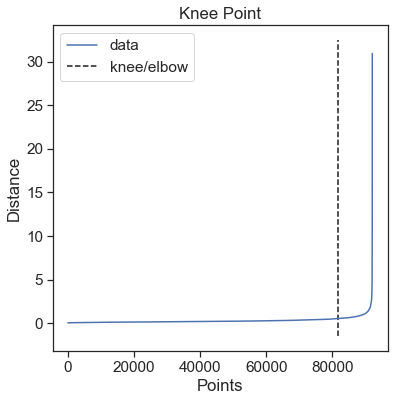

<Figure size 360x360 with 0 Axes>

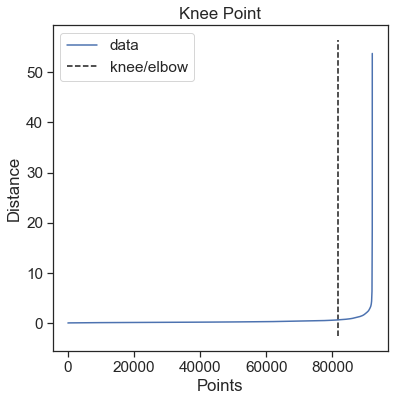

<Figure size 360x360 with 0 Axes>

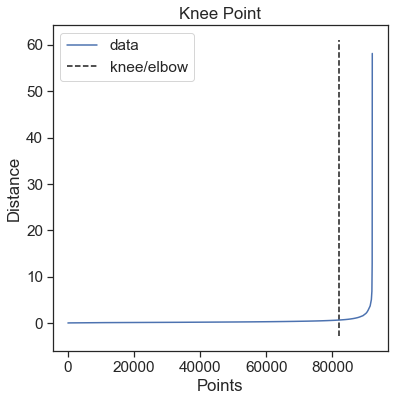

<Figure size 360x360 with 0 Axes>

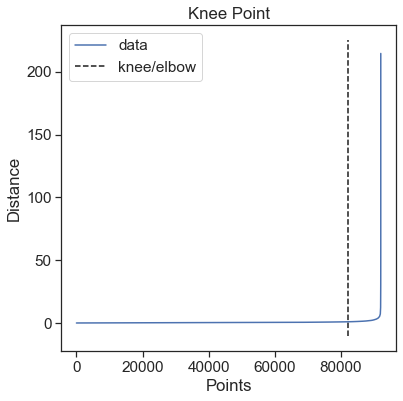

In [62]:
pca_components = [5, 10, 15, 20]
for n in pca_components:
    # Réduction de dimension
    pca = PCA(n_components=n)
    X_pca = pca.fit_transform(X_scaled)
    eps = find_eps(X_pca)
    print(eps)

In [67]:
def train_dbscan(data, verbose=1, save_all=False, save=True, name_csv='results_dbscan3'):
    model = 'DBSCAN'
    pca_components = [10, 20]
    hyp_param = 'eps, min_samples'
    epsilon = [0.67, 1.04]
    min_samples = [60, 80, 100]
    results = []
    cwd = os.getcwd()
    path = cwd + '/' + name_csv +  '.csv'
    columns=['Modèle', 
             'n_pca', 
             'Hyperparamètres', 
             'epsilon', 
             'min_samples',
             'n_clusters',
#              'WCSS',  # pour le DBSCAN la mesure du WCSS n'est pas pertinente car les clusters ne sont pas forcément sphériques
             'Silhouette', 
             'Davies_Bouldin', 
             'Calisnki-Har.', 
             'Temps de calcul']

    # Scaling
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(data)
    
    for i in range(2):
        
        # Réduction de dimension
        pca = PCA(n_components=pca_components[i])
        X_pca = pca.fit_transform(X_scaled)
        variance_expl = sum(pca.explained_variance_ratio_)
        
        for m in min_samples:

            start = time.time()

            # Clustering
            dbscan = DBSCAN(eps=epsilon[i], 
                            min_samples= m)
            dbscan.fit(X_pca)
            yhat = dbscan.fit_predict(X_pca)

#                 # On récupère les clusters
#                 clusters = unique(yhat)

            # Nombre de clusters, bruit ignoré
            labels = dbscan.labels_
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise_ = list(labels).count(-1)

            # Scores
            silhouette = round(silhouette_score(X_pca, yhat, metric='euclidean'),3)
            davies_bouldin = round(davies_bouldin_score(X_pca, yhat),3)
            calinski_harabasz = round(calinski_harabasz_score(X_pca, yhat))
            temps = round(time.time() - start)

            # Enregistrement des résultats
            results.append([model, 
                            pca_components[i], 
                            hyp_param, 
                            epsilon[i], 
                            m,
                            n_clusters_,
#                                 wcss, 
                            silhouette, 
                            davies_bouldin, 
                            calinski_harabasz, 
                            temps])
            if verbose == 1:
                print("model =", model, "    n_pca = ", pca_components[i],  "    epsilon=", epsilon[i], '\n', "    min_samples=", m, '\n', "    n_clusters=", n_clusters_, '\n',
#                           "within cluster SS = ", wcss, '\n',
                      "silhouette_score =", silhouette,'\n',
                      "davies_bouldin_score =", davies_bouldin,'\n',
                      "calinski_harabasz_score =", calinski_harabasz,'\n',
                      "temps de calcul: ", temps,
                      "\n\n", "-------------------------------", "\n")
            if save_all == True:
                df = pd.DataFrame(results, columns=columns)
                df.to_csv(path)
                
    df = pd.DataFrame(results, columns=columns)
    
    # Sauvegarde au format .csv
    if save==True:
        df.to_csv(path)
    return df

In [57]:
def tracer_scores(df_resultats):
    # Réarrangement des colonnes
    scores = ['Silhouette', 'Davies_Bouldin', 'Calisnki-Har.']
    columns = ['n_pca', 'epsilon', 'min_samples', 'n_clusters', 'score_value', 'score_type']
    df0 = df_resultats[['n_pca', 'epsilon', 'min_samples', 'n_clusters']]
    df_res = pd.DataFrame(columns=columns)
    for s in scores:
        df = df0.copy()
        df['score_value'] = df_resultats[s].copy()
        df['score_type'] = s
        df_res = pd.concat([df_res, df], ignore_index=True)

    df_res = df_res.astype({'n_pca': 'int32',
                  'epsilon': 'float',
                  'min_samples': 'int32',
                  'n_clusters': 'int32',     
                  'score_value':'float'})
    
    # Graphes scores
    sns.relplot(
        data=df_res, kind="scatter",
        x="n_clusters", 
        y="score_value", 
        hue="n_pca",
        facet_kws=dict(sharey=False),
        col="score_type",
        col_wrap=2,
#         linewidth =5,
        palette=["#FF0B04", "#4374B3"]
    )

In [70]:
# Résultats DBSCAN
results_dbscan = train_dbscan(data2)
results_dbscan

model = DBSCAN     n_pca =  10     epsilon= 0.67 
     min_samples= 60 
     n_clusters= 22 
 silhouette_score = 0.194 
 davies_bouldin_score = 1.81 
 calinski_harabasz_score = 3005 
 temps de calcul:  243 

 ------------------------------- 

model = DBSCAN     n_pca =  10     epsilon= 0.67 
     min_samples= 80 
     n_clusters= 21 
 silhouette_score = 0.179 
 davies_bouldin_score = 1.802 
 calinski_harabasz_score = 2948 
 temps de calcul:  248 

 ------------------------------- 

model = DBSCAN     n_pca =  10     epsilon= 0.67 
     min_samples= 100 
     n_clusters= 18 
 silhouette_score = 0.176 
 davies_bouldin_score = 1.883 
 calinski_harabasz_score = 3171 
 temps de calcul:  247 

 ------------------------------- 

model = DBSCAN     n_pca =  20     epsilon= 1.04 
     min_samples= 60 
     n_clusters= 23 
 silhouette_score = 0.206 
 davies_bouldin_score = 1.961 
 calinski_harabasz_score = 2597 
 temps de calcul:  440 

 ------------------------------- 

model = DBSCAN     n_pca

Modèle  n_pca   Hyperparamètres  epsilon  min_samples  n_clusters  \
0  DBSCAN     10  eps, min_samples     0.67           60          22   
1  DBSCAN     10  eps, min_samples     0.67           80          21   
2  DBSCAN     10  eps, min_samples     0.67          100          18   
3  DBSCAN     20  eps, min_samples     1.04           60          23   
4  DBSCAN     20  eps, min_samples     1.04           80          21   
5  DBSCAN     20  eps, min_samples     1.04          100          21   

   Silhouette  Davies_Bouldin  Calisnki-Har.  Temps de calcul  
0       0.194           1.810           3005              243  
1       0.179           1.802           2948              248  
2       0.176           1.883           3171              247  
3       0.206           1.961           2597              440  
4       0.193           1.942           2665              441  
5       0.180           1.906           2555              439

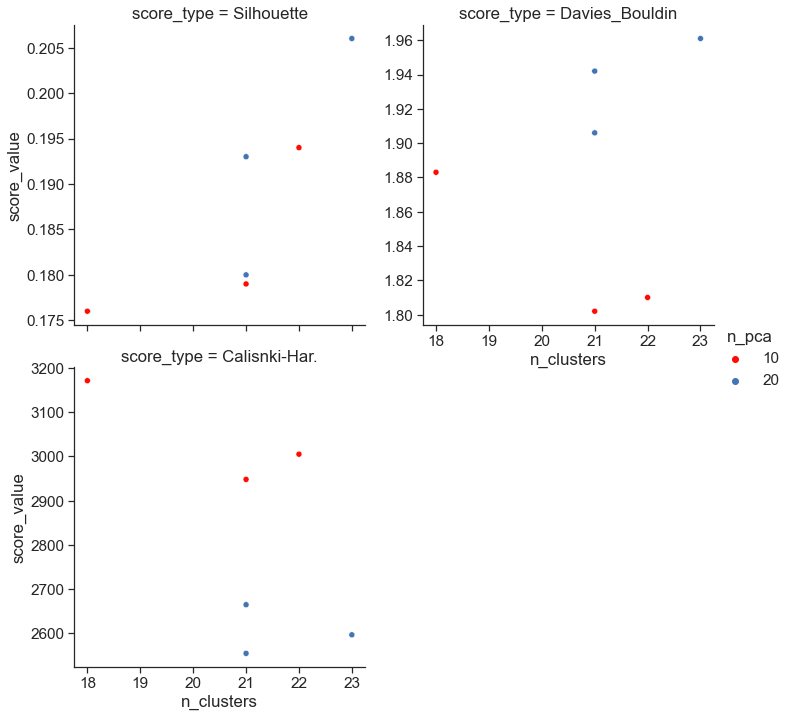

In [71]:
tracer_scores(results_dbscan)

### Stabilité dans le temps
Il nous est demandé d'envisager un contrat de maintenance pour savoir à quelle fréquence il est nécessaire de recalculer les clusters en fonction des nouvelles données.

Pour ce faire on peut vérifier la stabilité dans le temps des clusters en entraînant nos clusters sur des périodes de temps différentes.

On va se consituer une "base" sur une année, et voir l'effet de la mise à jour de cette base:
- tous les mois
- tous les 3 mois
- tous les 6 mois

In [52]:
import warnings
warnings.filterwarnings("ignore")

In [53]:
from datetime import datetime, timedelta

In [54]:
# Chargement des datasets
customers = pd.read_csv('olist_customers_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payments = pd.read_csv('olist_order_payments_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
product_category_name_translation = pd.read_csv('product_category_name_translation.csv')

In [55]:
# Supression valeurs manquantes
orders = orders.dropna()
products = products.dropna()

In [56]:
# Conversion en dates
for feat in ['order_purchase_timestamp',
            'order_approved_at', 
            'order_delivered_carrier_date',
            'order_delivered_customer_date', 
            'order_estimated_delivery_date']:   
    orders.loc[:,feat] = pd.to_datetime(orders[feat])

# Tri par ordre chronolique
orders = orders.sort_values(by='order_purchase_timestamp')

In [57]:
# Dictionnaire des correspondances (fait à la main)
dict_categories = {'bed_bath_table' : 'maison', 
                  'sports_leisure': 'sport', 
                  'furniture_decor' : 'maison', 
                  'health_beauty' : 'produits_beaute',
       'housewares' : 'maison', 
       'auto' : 'automobile', 
       'computers_accessories' : 'informatique', 
       'toys' : 'jouets', 
       'watches_gifts' : 'mode',
       'telephony' : 'informatique', 
       'baby' : 'bebe', 
       'perfumery' : 'produits_beaute', 
       'stationery' : 'bureau',
       'fashion_bags_accessories' : 'mode', 
       'cool_stuff' : 'cool_stuff', 
       'garden_tools' : 'bricolage', 
       'pet_shop' : 'animaux',
       'electronics' : 'informatique', 
       'construction_tools_construction' : 'bricolage', 
       'home_appliances' : 'maison',
       'luggage_accessories' : 'automobile', 
       'consoles_games' : 'informatique', 
       'office_furniture' : 'bureau',
       'musical_instruments'  : 'divertissement', 
       'small_appliances' : 'maison', 
       'home_construction' : 'bricolage',
       'books_general_interest' : 'divertissement', 
       'fashion_shoes' : 'mode', 
       'furniture_living_room' : 'maison',
       'air_conditioning' : 'maison', 
       'books_technical' : 'divertissement', 
       'fixed_telephony' : 'informatique',
       'home_confort' : 'maison', 
       'market_place' : 'industriel', 
       'food_drink' : 'alimentation', 
       'fashion_male_clothing' : 'mode',
       'kitchen_dining_laundry_garden_furniture' : 'maison', 
       'signaling_and_security' : 'bricolage',
       'construction_tools_safety' : 'bricolage', 
       'home_appliances_2' : 'maison',
       'costruction_tools_garden' : 'bricolage', 
       'food' : 'alimentation', 
       'drinks' : 'alimentation',
       'construction_tools_lights' : 'bricolage', 
       'agro_industry_and_commerce' : 'industriel',
       'industry_commerce_and_business' : 'industriel', 
       'christmas_supplies' : 'maison', 
       'audio' : 'informatique', 
       'art' : 'divertissement',
       'fashion_underwear_beach' : 'mode', 
       'dvds_blu_ray' : 'divertissement', 
       'furniture_bedroom' : 'maison',
       'costruction_tools_tools' : 'bricolage', 
       'books_imported' : 'divertissement',
       'small_appliances_home_oven_and_coffee' : 'maison', 
       'computers' : 'informatique', 
       'cine_photo' : 'divertissement',
       'fashio_female_clothing' : 'mode', 
       'music' : 'divertissement', 
       'party_supplies' : 'maison',
       'arts_and_craftmanship' : 'bricolage', 
       'fashion_sport' : 'mode', 
       'flowers' : 'maison',
       'diapers_and_hygiene' : 'bebe', 
       'la_cuisine' : 'maison',
       'furniture_mattress_and_upholstery' : 'maison', 
       'tablets_printing_image' : 'informatique',
       'fashion_childrens_clothes' : 'mode', 
       'home_comfort_2' : 'maison', 
       'security_and_services' : 'services',
       'cds_dvds_musicals' : 'divertissement'}

In [58]:
aggregations = {
'payment_installments': 'max',  # on garde le max (en combien de fois a payé le client)
'payment_value': 'sum'          # on en fait la somme pour trouver le montant total de la commande
}

aggregations_final = {
    'order_purchase_timestamp': lambda x: (last_day - x.max()).days,  
    'order_id' : 'size',
    'payment_value' : 'sum', 
    'delai_livraison' : 'mean',
    'retard_livraison' : 'mean', 
    'review_score' : 'mean',
    'payment_installments' : 'mean',
    'categories_alimentation' : 'sum',
    'categories_animaux' : 'sum', 
    'categories_automobile' : 'sum', 
    'categories_bebe' : 'sum',     
    'categories_bricolage' : 'sum', 
    'categories_bureau' : 'sum', 
    'categories_cool_stuff' : 'sum',    
    'categories_divertissement' : 'sum', 
    'categories_industriel' : 'sum',     
    'categories_informatique' : 'sum', 
    'categories_jouets' : 'sum', 
    'categories_maison' : 'sum',    
    'categories_mode' : 'sum', 
    'categories_produits_beaute' : 'sum', 
    'categories_services' : 'sum',
    'categories_sport' : 'sum'
#     'customer_state_AC' : 'first',     
#     'customer_state_AL' : 'first', 
#     'customer_state_AM' : 'first', 
#     'customer_state_AP' : 'first',     
#     'customer_state_BA' : 'first', 
#     'customer_state_CE' : 'first', 
#     'customer_state_DF' : 'first',   
#     'customer_state_ES' : 'first', 
#     'customer_state_GO' : 'first', 
#     'customer_state_MA' : 'first',     
#     'customer_state_MG' : 'first', 
#     'customer_state_MS' : 'first', 
#     'customer_state_MT' : 'first',    
#     'customer_state_PA' : 'first', 
#     'customer_state_PB' : 'first', 
#     'customer_state_PE' : 'first',      
#     'customer_state_PI' : 'first', 
#     'customer_state_PR' : 'first', 
#     'customer_state_RJ' : 'first',      
#     'customer_state_RN' : 'first', 
#     'customer_state_RO' : 'first', 
#     'customer_state_RR' : 'first',     
#     'customer_state_RS' : 'first', 
#     'customer_state_SC' : 'first', 
#     'customer_state_SE' : 'first', 
#     'customer_state_SP' : 'first', 
#     'customer_state_TO' : 'first'
}


On crée une fonction qui nous permet de faire le même travail que dans le premier notebook, mais sur une période de temps spécifique.

In [59]:
def creer_df(start_day, deltaT):
    '''
    Fonction qui permet de créer un jeu de données sur la
    période entre start_day et start_day + deltaT (en jours).
    '''
    # Sélection des données dans la période
    mask = (orders['order_purchase_timestamp'] > start_day) & (orders['order_purchase_timestamp'] <= start_day+deltaT)
    df_orders = orders[mask]
    last_day = df_orders['order_purchase_timestamp'].max()
    
    # Score par commande:
    df_order_reviews = order_reviews.sort_values(by=['order_id', 'review_creation_date'])
    df_order_reviews = df_order_reviews.groupby('order_id').last().reset_index()
    df_order_reviews = df_order_reviews[['order_id','review_score']]

    # Groupby sur la variable 'order_id'
    df_order_payments = order_payments.groupby('order_id').agg(aggregations).reset_index()

    # On ajoute les traductions en anglais
    df_products = products.merge(product_category_name_translation)
    
   # On ajoute les nouvelles catégories 
    df_products['categories'] = df_products['product_category_name_english'].replace(dict_categories)
    
    # Suppression des variables inutiles
    df_products = df_products[['product_id', 'categories']]
      
    # Les catégories peuvent maintenant être ajoutées aux ordres
    df_order_items = order_items.merge(df_products)
    df_order_items = df_order_items[['order_id', 'categories']]
    
    # Encodage de la variable "categories"
    df_order_items = pd.get_dummies(df_order_items, columns=['categories'])
    
    # Un ordre peut contenir plusieurs objets et donc plusieurs catégories:
    df_order_items = df_order_items.groupby('order_id').sum().reset_index()
    
    # Création des deux nouvelles variables
    df_orders.loc[:,'delai_livraison'] = df_orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']
    df_orders.loc[:,'delai_livraison'] = df_orders['delai_livraison'].dt.days
    df_orders.loc[:,'retard_livraison'] = df_orders['order_delivered_customer_date'] - orders['order_estimated_delivery_date']
    df_orders.loc[:,'retard_livraison'] = df_orders['retard_livraison'].dt.days
    
    # Suppression des variables inutiles sur 'orders'
    df_orders = df_orders[['order_id',
                         'customer_id',
                        'order_purchase_timestamp',
                        'delai_livraison', 
                        'retard_livraison']]
    
    # Regroupement de toutes les variables
    dataframes = [df_orders, df_order_reviews, df_order_payments, df_order_items]
    
    data = reduce(lambda left, right: pd.merge(left, right, on='order_id'), dataframes)
    data = data.merge(customers)
    
    # Groupby final sur la variable 'customer_unique_id'
    data = data.groupby('customer_unique_id').agg(aggregations_final).reset_index()
    data = data.rename(columns={'order_purchase_timestamp': 'Recence', 'order_id': 'Frequence', 'payment_value':'Montant'})
    data = data.set_index('customer_unique_id')
    
    return data

In [60]:
# On peut s'assurer qu'on retombe sur le dataframe original si on prend toute la période disponible
first_day = datetime(2016,10,7)
last_day = orders['order_purchase_timestamp'].max()
deltaT = last_day-first_day
data = creer_df(first_day, deltaT)
data

Recence  Frequence  Montant  \
customer_unique_id                                              
0000366f3b9a7992bf8c76cfdf3221e2      111          1   141.90   
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1    27.19   
0000f46a3911fa3c0805444483337064      536          1    86.22   
0000f6ccb0745a6a4b88665a16c9f078      320          1    43.62   
0004aac84e0df4da2b147fca70cf8255      287          1   196.89   
...                                   ...        ...      ...   
fffcf5a5ff07b0908bd4e2dbc735a684      446          1  2067.42   
fffea47cd6d3cc0a88bd621562a9d061      261          1    84.58   
ffff371b4d645b6ecea244b27531430a      567          1   112.46   
ffff5962728ec6157033ef9805bacc48      118          1   133.69   
ffffd2657e2aad2907e67c3e9daecbeb      483          1    71.56   

                                  delai_livraison  retard_livraison  \
customer_unique_id                                                    
0000366f3b9a7992bf8c76cfdf3221e2              6.0              -5.0   
0000b849f77a49e4a4ce2b2a4ca5be3f              3.0              -5.0   
0000f46a3911fa3c0805444483337064             25.0              -2.0   
0000f6ccb0745a6a4b88665a16c9f078             20.0             -12.0   
0004aac84e0df4da2b147fca70cf8255             13.0              -8.0   
...                                           ...               ...   
fffcf5a5ff07b0908bd4e2dbc735a684             27.0             -27.0   
fffea47cd6d3cc0a88bd621562a9d061             30.0              -3.0   
ffff371b4d645b6ecea244b27531430a             14.0             -30.0   
ffff5962728ec6157033ef9805bacc48             11.0             -14.0   
ffffd2657e2aad2907e67c3e9daecbeb              7.0             -16.0   

                                  review_score  payment_installments  \
customer_unique_id                                                     
0000366f3b9a7992bf8c76cfdf3221e2           5.0                   8.0   
0000b849f77a49e4a4ce2b2a4ca5be3f           4.0                   1.0   
0000f46a3911fa3c0805444483337064           3.0                   8.0   
0000f6ccb0745a6a4b88665a16c9f078           4.0                   4.0   
0004aac84e0df4da2b147fca70cf8255           5.0                   6.0   
...                                        ...                   ...   
fffcf5a5ff07b0908bd4e2dbc735a684           5.0                  10.0   
fffea47cd6d3cc0a88bd621562a9d061           4.0                   1.0   
ffff371b4d645b6ecea244b27531430a           5.0                   1.0   
ffff5962728ec6157033ef9805bacc48           5.0                   5.0   
ffffd2657e2aad2907e67c3e9daecbeb           5.0                   4.0   

                                  categories_alimentation  categories_animaux  \
customer_unique_id                                                              
0000366f3b9a7992bf8c76cfdf3221e2                        0                   0   
0000b849f77a49e4a4ce2b2a4ca5be3f                        0                   0   
0000f46a3911fa3c0805444483337064                        0                   0   
0000f6ccb0745a6a4b88665a16c9f078                        0                   0   
0004aac84e0df4da2b147fca70cf8255                        0                   0   
...                                                   ...                 ...   
fffcf5a5ff07b0908bd4e2dbc735a684                        0                   0   
fffea47cd6d3cc0a88bd621562a9d061                        0                   0   
ffff371b4d645b6ecea244b27531430a                        0                   0   
ffff5962728ec6157033ef9805bacc48                        0                   0   
ffffd2657e2aad2907e67c3e9daecbeb                        0                   0   

                                  categories_automobile  ...  \
customer_unique_id                                       ...   
0000366f3b9a7992bf8c76cfdf3221e2                      0  ...   
0000b849f77a49e4a4ce2b2a4ca5be3f                      0  ...   
0000f46a3911fa3c0

In [61]:
# On réutilise le modèle le plus pertinent:
def kmeans(df , n_clusters, n_pca=10):
    # Scaling
    sc = preprocessing.StandardScaler()
    X_scaled = sc.fit_transform(df)

    # ACP
    pca = PCA(n_components=n_pca)
    X_pca = pca.fit_transform(X_scaled)

    # Clustering
    km = KMeans(n_clusters=n_clusters,
               init='k-means++',
               random_state=10)
    km.fit(X_pca)
    
    df['clusters'] = km.labels_
    
    return df['clusters']

In [62]:
from sklearn.metrics import adjusted_rand_score

In [63]:
import plotly
import chart_studio.plotly as py
import plotly.graph_objects as go

In [64]:
def creer_label(n_clusters, n_delta):
    """
    Permet de créer les labels des différents niveaux du diagramme de Sankey
    """
    label=[]
    for i in range(n_delta+1):
        for k in range(n_clusters+1):
            lab = str(k-1) +',' +str(i)
            label.append(lab)
            
    return label

In [65]:
def sankey(n_mois, n_delta, n_clusters=6, first_day=datetime(2016,10,7), base_period=timedelta(days=365)):
    """
    Réalise un diagramme de Sankey de l'évolution des flux des clients 
    entre les clusters sur diférents horizons de temps
    """
    deltaT = timedelta(days=n_mois*30.5)
    
    # Création des clusters pour chaque période
    # Période initiale
    base = creer_df(first_day, base_period)
    df = kmeans(base, n_clusters)

    # Périodes succesives de deltaT
    for i in range(n_delta):
        df2 = creer_df(first_day, base_period+(i+1)*deltaT)
        df2 = kmeans(df2, n_clusters)
        df2 =df2.rename('lvl'+str(i+1))
#         df = pd.merge([df, df2], how=outer)
        df = pd.concat([df, df2], axis=1)
    
    df = df.fillna(-1)  # le label -1 correspondond aux nouveaux arrivants
        
    df_sankey= df.groupby(df.columns.tolist()).size().reset_index().\
    rename(columns={0:'counts'})
    
    # Création des données de Sankey
    label = creer_label(n_clusters, n_delta)
    target = []
    source = []
    value =[]
    for i in range(n_delta):
        target_temp = df_sankey.iloc[:,i+1] + (n_clusters+1)*(i+1) +1
        target_temp = target_temp.tolist()
        target = target + target_temp

        source_temp = df_sankey.iloc[:,i]+ (n_clusters+1)*(i) +1
        source_temp = source_temp.tolist()
        source = source + source_temp

        value = value + df_sankey.iloc[:,-1].tolist()

    # Création figure de Sankey
    fig = go.Figure(layout_title_text=f'Evolution des flux clients pour {n_clusters} clusters tous les {n_mois} mois',
                    data=[go.Sankey(
        node = dict(
          thickness = 5,
          line = dict(color = "green", width = 0.1),
          label = label,
          color = "blue"
        ),
        link = dict(
          source = source,
          target = target,
          value = value,
      ))])
    
    """ 
    On ne peut pas calculer la similarité entre les clusters à t et t+1 car les 
    labels des clusters varient entre les deux
    # Affichage des scores de Rand (similraité entre clusters)
    for n in range(n_delta):
        score = adjusted_rand_score(df_sankey.iloc[:,n],df_sankey.iloc[:,n+1])
        print(f'Adjusted Rand score between T{n} and T{n+1}: {score:.3f}')
    """
    fig.show()

Le premier chiffre correspond au label du cluster, le second à la date considérée.

In [66]:
%%time
sankey(n_mois=1, n_delta=2, n_clusters=6)

Wall time: 20.3 s


In [67]:
%%time
sankey(n_mois=1, n_delta=6, n_clusters=6)

Wall time: 54.9 s


In [68]:
%%time
sankey(n_mois=3, n_delta=2, n_clusters=6)

Wall time: 23.1 s


In [69]:
%%time
sankey(n_mois=3, n_delta=4, n_clusters=6)

Wall time: 49.4 s


In [70]:
%%time
sankey(n_mois=6, n_delta=2, n_clusters=6)

Wall time: 30.8 s


In [71]:
%%time
sankey(n_mois=1, n_delta=6, n_clusters=9)

Wall time: 56.4 s


In [72]:
%%time
sankey(n_mois=3, n_delta=4, n_clusters=9)

Wall time: 52.8 s


In [73]:
%%time
sankey(n_mois=6, n_delta=2, n_clusters=9)

Wall time: 32.1 s


### Conclusion
L 'algorithme KMeans permet de faire ressortir certains insights intéressants sur ce jeu de données. De même pour la segmentation RFM qui permet une segmentation client plus contrôlée. La forte croissance en nouveaux clients oblige à recalculer les clusters assez régulièrement, par exemple tous les 3 mois.

Annexe:

In [14]:
def RFM(df):
    R_score = pd.qcut(df['Recence'], 3, labels=[1, 2, 3]).astype(str)
    M_score = pd.qcut(df['Montant'], 3, labels=[1, 2, 3]).astype(str)
    F_score = df['Frequence'].apply(lambda x: '1' if x==1 else '2')

    RFM_score = R_score + M_score + F_score
    segments = RFM_score.apply(segment)
    
    return segments